# Advanced Lane Detection Video Project
## Now we will recreate some function which can be used for the sanity checks and process the final function for the videos included in the project

In [2]:
## Import all the relevant python libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt

In [3]:
def display_images(img1=[], img2=[], cmap=None, label1=[], label2=[], img3=[], label3=[], img4=[], label4=[], n=2):
    plt.figure(figsize=(24, 9))
    plt.subplot(1, n, 1)
    plt.imshow(img1, cmap = cmap)
    plt.xlabel(label1, fontsize=20)
    plt.subplot(1, n, 2)
    plt.imshow(img2, cmap = cmap)
    plt.xlabel(label2, fontsize=20)
    if n == 3:
        plt.subplot(1, n, 3)
        plt.imshow(img3, cmap = cmap)
        plt.xlabel(label3, fontsize=20)
    elif n == 4:
        plt.subplot(1, n, 3)
        plt.imshow(img3, cmap = cmap)
        plt.xlabel(label3, fontsize=20)
        plt.subplot(1, n, 4)
        plt.imshow(img4, cmap = cmap)
        plt.xlabel(label4, fontsize=20)

In [4]:
# Arrays to store object points and image points from all the images.
cal_images = glob.glob('camera_cal/*.jpg')
nx, ny = 9, 6

objpoints = []  # 3D points
imgpoints = []  # 2D points
    
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

for file in cal_images:
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
# This function is for performing the undistortion of the provided image. This needs the Camera matrix, distortion 
# coefficients and the original image as inputs
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
# This is a function to perform the perspective transform of the image
def perspective_transform(img):
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    # Providing default source and destination points on the image
    # Define the region of interest
    #src = np.float32([[190, 700], [1110, 700], [780, 470], [570, 470]])
    #dst = np.float32([[200, 700], [1050, 700], [1050, 1], [320, 1]])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    #undist_img= cal_undistort(img, mtx, dist)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img , M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def inv_perspective_transform(img):
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    # Providing default source and destination points on the image
    # Define the region of interest
    #src = np.float32([[190, 700], [1110, 700], [780, 470], [570, 470]])
    #dst = np.float32([[200, 700], [1050, 700], [1050, 1], [320, 1]])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img , M_inv, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [7]:
# image processing function

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply threshold
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    sobel_output = np.zeros_like(scaled_sobel)
    # Here we will be using using inclusive (>=, <=) thresholds, but exclusive is ok too
    sobel_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_output

def HLS_process_img(image, channel='h', thresh =(200,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    if channel == 'h':
        HLSbinary = np.zeros_like(H)
        HLSbinary[(H > thresh[0]) & (H <= thresh[1])] = 1
    if channel == 'l':
        HLSbinary = np.zeros_like(L)
        HLSbinary[(L > thresh[0]) & (L <= thresh[1])] = 1
    if channel == 's':
        HLSbinary = np.zeros_like(S)
        HLSbinary[(S > thresh[0]) & (S <= thresh[1])] = 1  
    return HLSbinary, H, L, S
def LAB_process_img(image, channel='l', thresh =(200,255)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]
    if channel == 'l':
        LABbinary = np.zeros_like(L)
        LABbinary[(L > thresh[0]) & (L <= thresh[1])] = 1
    if channel == 'a':
        LABbinary = np.zeros_like(A)
        LABbinary[(A > thresh[0]) & (A <= thresh[1])] = 1
    if channel == 'b':
        LABbinary = np.zeros_like(B)
        LABbinary[(B > thresh[0]) & (B <= thresh[1])] = 1  
    return LABbinary, L, A, B

def LUV_process_img(image, channel='l', thresh =(200,255)):
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    L = luv[:,:,0]
    U = luv[:,:,1]
    V = luv[:,:,2]
    if channel == 'l':
        LUVbinary = np.zeros_like(L)
        LUVbinary[(L > thresh[0]) & (L <= thresh[1])] = 1
    if channel == 'u':
        LUVbinary = np.zeros_like(U)
        LUVbinary[(U > thresh[0]) & (U <= thresh[1])] = 1
    if channel == 'v':
        LUVbinary = np.zeros_like(V)
        LUVbinary[(V > thresh[0]) & (V <= thresh[1])] = 1  
    return LUVbinary, L, U, V

def color_gradient_pipe(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    sobelimg = abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=sx_thresh)
    
    S_img, H, L, S = HLS_process_img(img, channel='s', thresh =s_thresh)
    
    color_binary = np.dstack(( np.zeros_like(sobelimg), sobelimg, S_img)) * 255
    combined_binary = np.zeros_like(sobelimg)
    combined_binary[(S_img == 1) | (sobelimg == 1)] = 1
    return combined_binary

def color_threshold_pipe(img):
    img = np.copy(img)
    
    lab_B_img, L, A, B = LAB_process_img(img, channel='b', thresh =(150,210))
    luv_L_img, L, U, V = LUV_process_img(img, channel='l', thresh =(210,255))
    
    color_binary = np.dstack(( np.zeros_like(lab_B_img), lab_B_img, luv_L_img)) * 255
    combined_binary = np.zeros_like(lab_B_img)
    combined_binary[(luv_L_img == 1) | (lab_B_img == 1)] = 1
    
    return combined_binary

In [8]:
# Pipeline for image processing
def Image_process_pipeline(image):
    image = cal_undistort(image, mtx, dist)
    ColorGradientImg = color_threshold_pipe(image)
    WarpedImg = perspective_transform(ColorGradientImg)
    return WarpedImg

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 50
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [10]:
def search_around_poly(Binaryimg_road, leftx, lefty, rightx, righty):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    
    margin = 50

    # Grab activated pixels
    nonzero = Binaryimg_road.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ### Now we need to set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [11]:
def fit_poly(BinaryImg, leftx, lefty, rightx, righty):
    
    img_shape = BinaryImg.shape
    nonzero = BinaryImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### to Calculate both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((BinaryImg, BinaryImg, BinaryImg))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    Mid_line_pts = np.hstack((left_line_window, right_line_window))
    # Draw the lane onto the warped blank image
    result = cv2.fillPoly(window_img, np.int_([Mid_line_pts]), (0,255, 0))
    ## End visualization steps ##
    
    return result

In [12]:
def fit_polyTest(BinaryImg, leftx, lefty, rightx, righty):
    
    img_shape = BinaryImg.shape
    margin = 50
    
    nonzero = BinaryImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### to Calculate both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((BinaryImg, BinaryImg, BinaryImg))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
   
    return result

In [13]:
def Calc_Curv(BinaryimgIn, InitialImg):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
        # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    leftx, lefty, rightx, righty = find_lane_pixels(BinaryimgIn)
    # Generate x and y values for plotting
    ploty = np.linspace(0, BinaryimgIn.shape[0]-1, BinaryimgIn.shape[0] )
    y_eval = np.max(ploty)
    
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        # Calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        AvgCurv = (left_curverad+right_curverad)/2
    if right_fit is not None and left_fit is not None:
            car_position = img.shape[1]/2
            l_fit_x_int = left_fit[0]*BinaryimgIn.shape[0]**2 + left_fit[1]*BinaryimgIn.shape[0] + left_fit[2]
            r_fit_x_int = right_fit[0]*BinaryimgIn.shape[0]**2 + right_fit[1]*BinaryimgIn.shape[0] + right_fit[2]
            lane_center_position = (r_fit_x_int + l_fit_x_int) /2
            center_dist = (car_position - lane_center_position) * xm_per_pix
            #return left_curveRad, right_curveRad, left_curveRad_real, right_curveRad_real
    Final_img = np.copy(InitialImg)
    h = Final_img.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = 'Radius of curvature: %.2f m' % AvgCurv
    cv2.putText(Final_img, text, (40,80), font, 1.0, (255,255,255), 2, cv2.LINE_AA)
    
    abs_center_dist = abs(center_dist)
    if center_dist > 0:
        text = '%.3f m right of center' % abs_center_dist
    elif center_dist < 0:
        text = '%.3f m left of center' % abs_center_dist
    
    cv2.putText(Final_img, text, (40,120), font, 1.0, (255,255,255), 2, cv2.LINE_AA)
    
    return Final_img

In [14]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def check_lane(self, fitx, fity):
        if fitx is not None or fity is not None :
            self.detected = False
            
        else:
            self.detected = True
            self.current_fitx.append(fitx)
            self.current_fity.append(fity)
            if len(self.current_fitx) > 4 and len(self.current_fity) > 4 :
                self.current_fitx = self.current_fitx[len(self.current_fitx)-4:]
                self.current_fity = self.current_fity[len(self.current_fity)-4:]
            self.best_fitx = np.average(self.current_fitx, axis=0)
            self.best_fity = np.average(self.current_fity, axis=0)

In [15]:
def LaneFindingPipeline(imgIn):
    left_lane = Line()
    right_lane = Line()
    
    BinaryImg = Image_process_pipeline(imgIn)
    
    if left_lane.detected is not True or right_lane.detected is not True:
        leftx, lefty, rightx, righty = find_lane_pixels(BinaryImg)
    else:
        leftx, lefty, rightx, righty = search_around_poly(BinaryImg, leftx, lefty, rightx, righty)
    
    left_lane.check_lane(leftx, lefty)
    right_lane.check_lane(rightx, righty)
    
    FitLinesImg = fit_poly(BinaryImg, leftx, lefty, rightx, righty)
    #FitLinesImg = fit_polyTest(BinaryImg, leftx, lefty, rightx, righty)
    
    unwarped = inv_perspective_transform(FitLinesImg)
    LaneImg= cv2.addWeighted(unwarped, 0.5, imgIn, 1, 0)
    
    Final_img = Calc_Curv(BinaryImg, LaneImg)

    return Final_img
    #return FitLinesImg

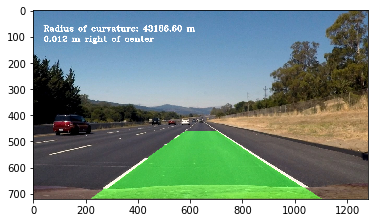

In [16]:
test_images = glob.glob('test_images/*.jpg')
img_test = cv2.imread(test_images[1])
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
ImgProcessWarped = LaneFindingPipeline(img_test)
plt.imshow(ImgProcessWarped)
#display_images(img1=img_test, img2=ImgProcessWarped, cmap = None, label1='Original Image', label2='Lane detected Image', n=2)

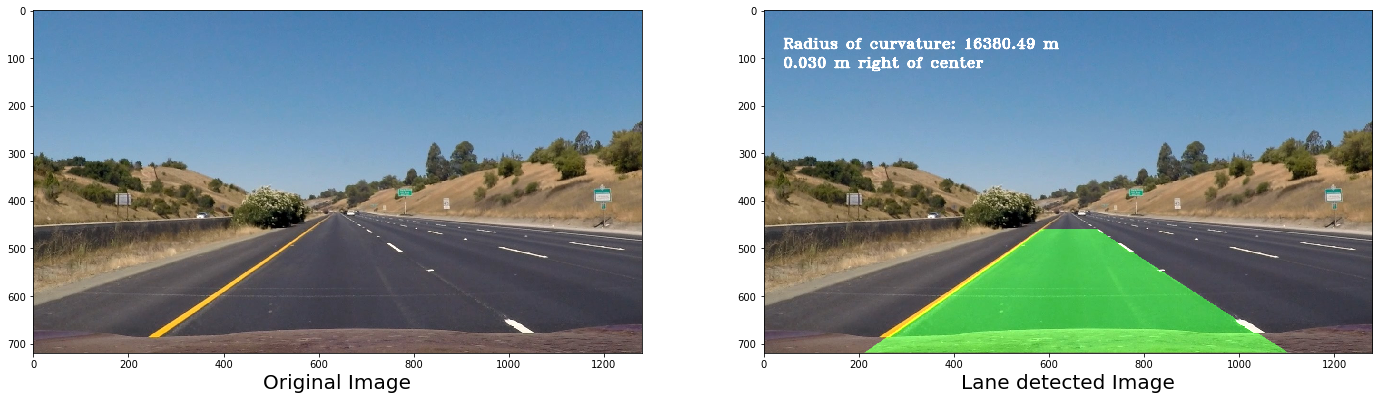

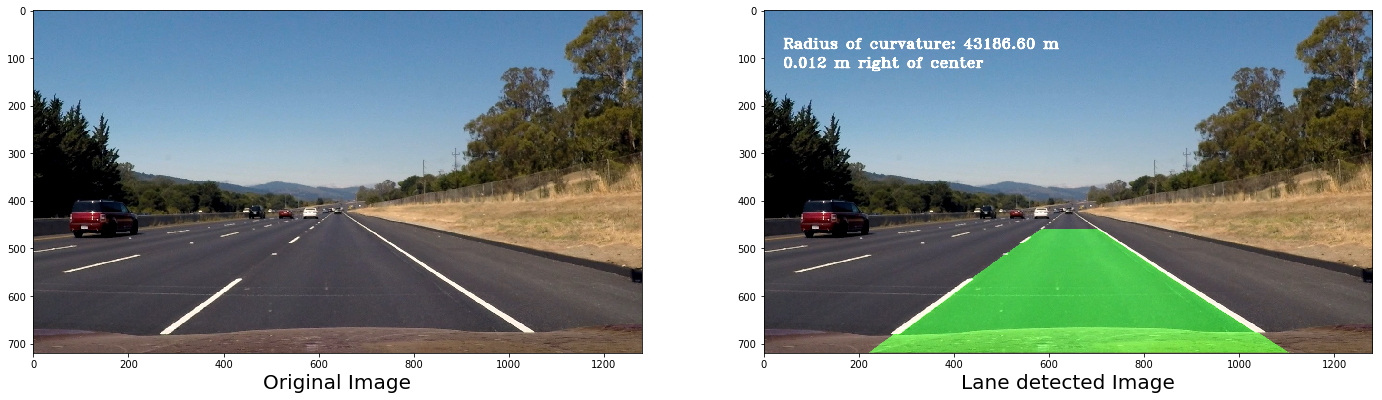

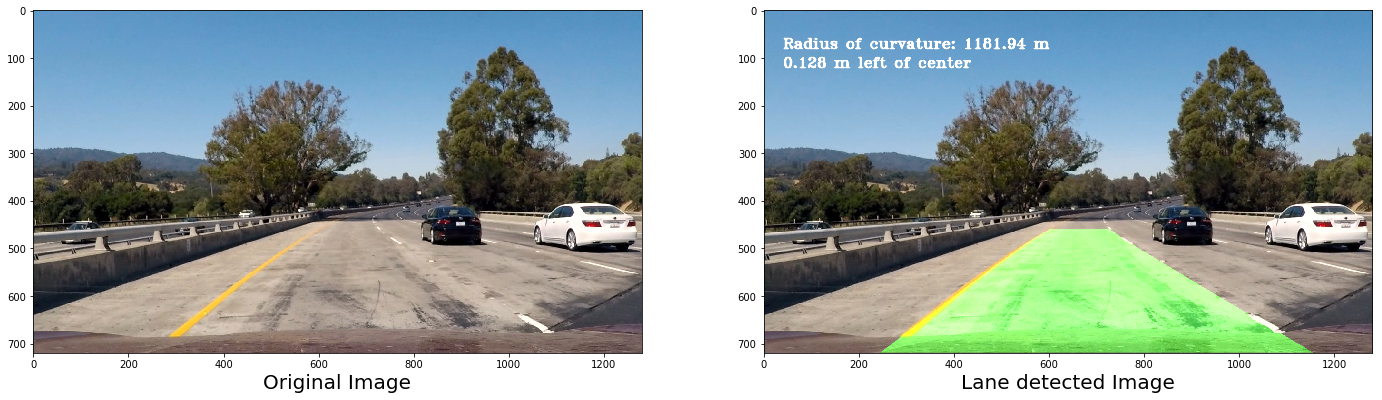

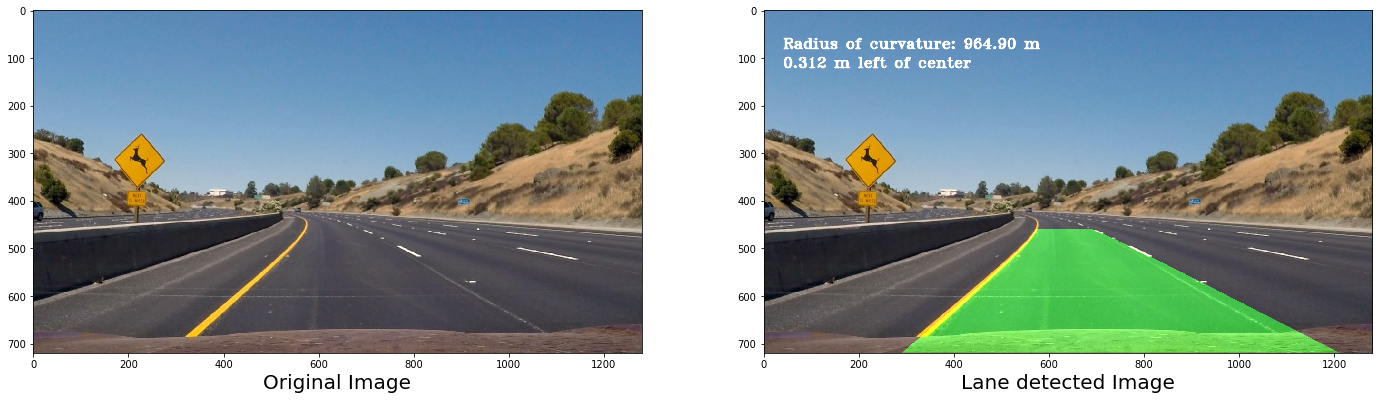

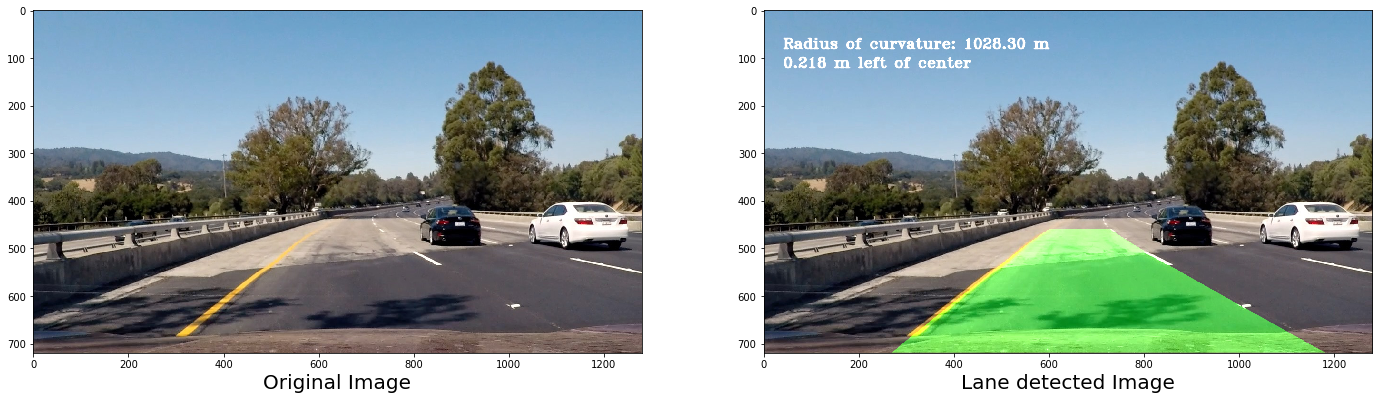

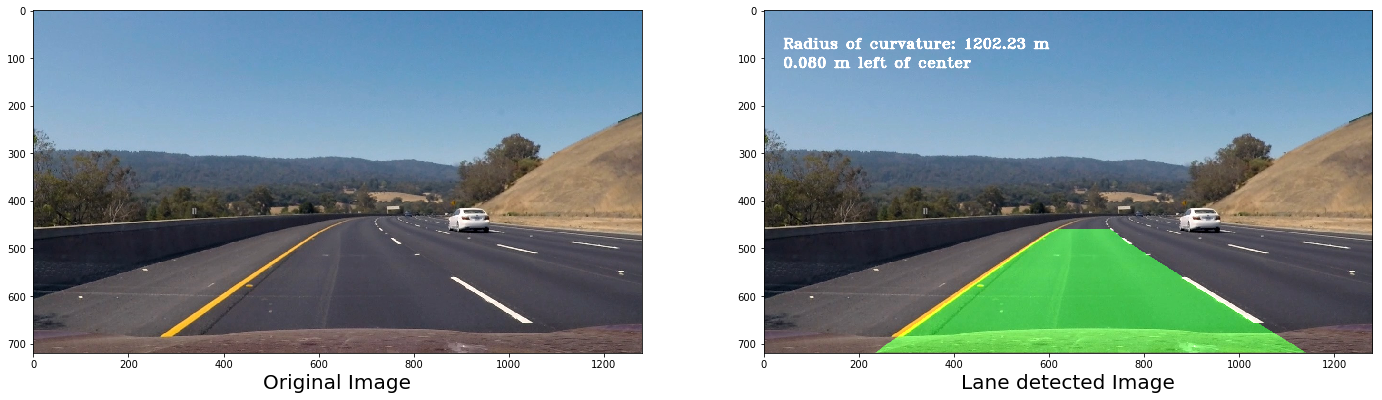

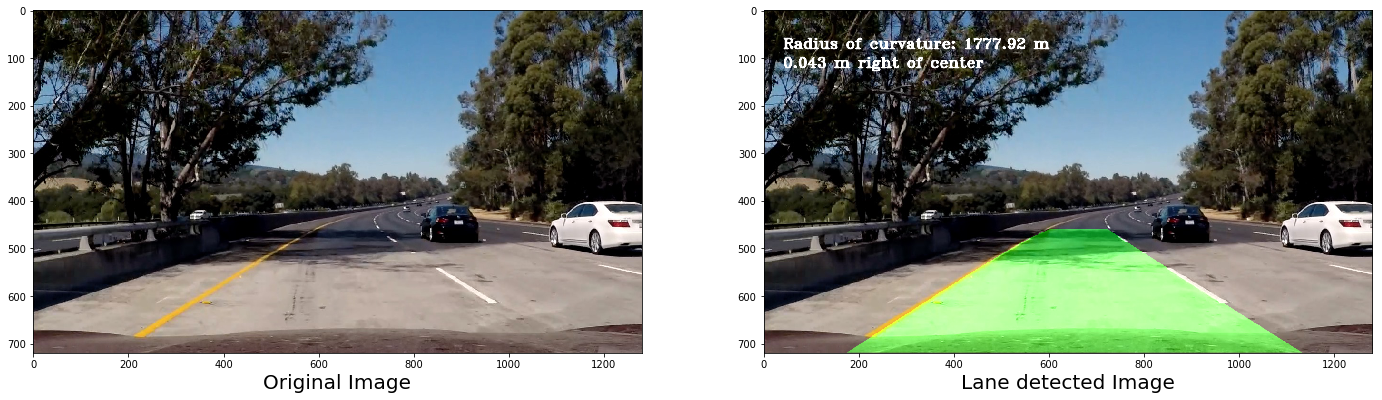

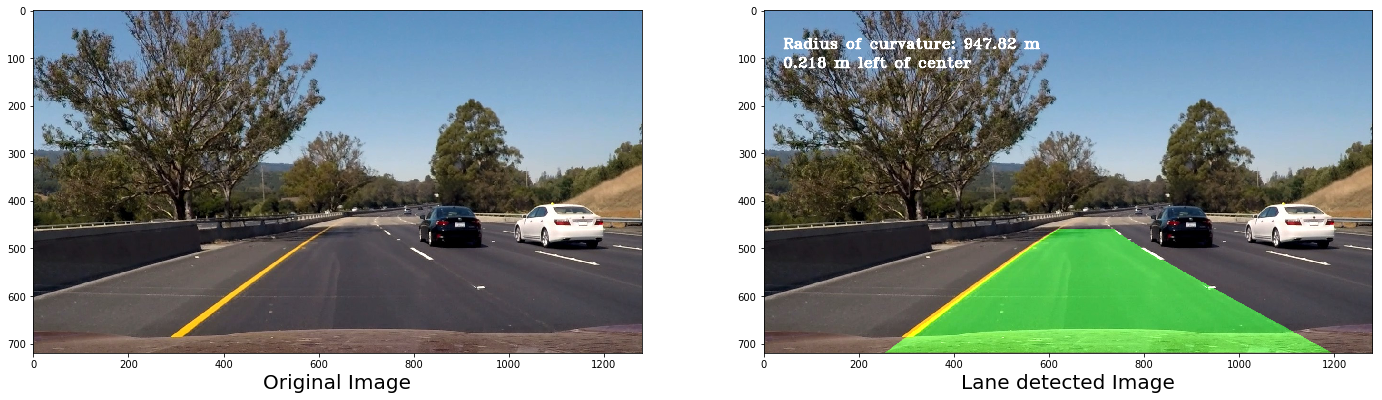

In [17]:
ReadTest_images = glob.glob('test_images/*.jpg')
for file in ReadTest_images:
    img_test = cv2.imread(file)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    ImgProcessWarped = LaneFindingPipeline(img_test)
    cv2.imwrite("test_image_output/output_"+file, ImgProcessWarped)
    display_images(img1=img_test, img2=ImgProcessWarped, cmap = None, label1='Original Image', label2='Lane detected Image', n=2)

In [18]:
Video_output = 'test_image_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(LaneFindingPipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(Video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Video_output))

[MoviePy] >>>> Building video test_image_output/project_video.mp4
[MoviePy] Writing video test_image_output/project_video.mp4


100%|█████████▉| 1260/1261 [05:49<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_image_output/project_video.mp4 

CPU times: user 3min 36s, sys: 9.01 s, total: 3min 45s
Wall time: 5min 52s


In [18]:
ChallengeVideo_output = 'test_image_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(LaneFindingPipeline) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(ChallengeVideo_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(ChallengeVideo_output))

[MoviePy] >>>> Building video test_image_output/challenge_video.mp4
[MoviePy] Writing video test_image_output/challenge_video.mp4


  1%|          | 6/485 [00:01<01:33,  5.11it/s]

TypeError: expected non-empty vector for x